In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
import xitorch
from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path

plt.rcParams['figure.figsize'] = 2*1.618, 2
plt.rcParams['figure.dpi'] = 300

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
def compute_eigenvalues(blocks, dataset, overlap_matrices = None, baseline = None):
    
    recon_HT = blocks_to_matrix(blocks, dataset, detach = True)
    recon_Hk = dataset.bloch_sum(recon_HT)
    
    if baseline is not None:
        for Hks, H0ks in zip(recon_Hk, baseline):
            for Hk, H0k in zip(Hks, H0ks):
                Hk += H0k
    
    if overlap_matrices is not None:
        recon_Sk = overlap_matrices
        # recon_ST = blocks_to_matrix(overlap_blocks, dataset)
        # recon_Sk = dataset.bloch_sum(recon_ST)
        is_ortho = False
    else:
        is_ortho = True
        
    eigvals = []
    if is_ortho:
        for Hk in recon_Hk:
            ek = []
            for h in Hk:
                ek.append(eigvalsh(h.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
    else:
        for Hk, Sk in zip(recon_Hk, recon_Sk):
            ek = []
            for h, s in zip(Hk, Sk):
                ek.append(eigvalsh(h.detach().cpu().numpy(), b = s.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
            
    return np.stack(eigvals), torch.stack(recon_Hk)

def rmse_vector(v1, v2):
    return np.sqrt(np.mean(np.abs(v1-v2)**2))

def mae_vector(v1, v2):
    return np.mean(np.abs(v1 - v2))

def rmse_blocks(tm1, tm2):
    allb1 = []
    allb2 = []
    assert mts.equal_metadata(tm1, tm2)
    for b1, b2 in zip(tm1.blocks(), tm2.blocks()):
        allb1.append(b1.values.detach().flatten())
        allb2.append(b2.values.detach().flatten())
    allb1 = torch.cat(allb1)
    allb2 = torch.cat(allb2)
    return rmse_vector(allb1.numpy(), allb2.numpy())

def mae_blocks(tm1, tm2):
    allb1 = []
    allb2 = []
    assert mts.equal_metadata(tm1, tm2)
    for b1, b2 in zip(tm1.blocks(), tm2.blocks()):
        allb1.append(b1.values.detach().flatten())
        allb2.append(b2.values.detach().flatten())
    allb1 = torch.cat(allb1)
    allb2 = torch.cat(allb2)
    return mae_vector(allb1.numpy(), allb2.numpy())

# Info

In [4]:
root = '/scratch/pegolo/mos2'
nhidden = 64
nlayers = 1
device = 'cpu'
cutoff = 8
overwrite = True

results_dir = f'{root}/test_results'
Path(results_dir).mkdir(exist_ok = overwrite)

device = 'cpu'
orbitals = {
     'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]},
     'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
     'gthszvmolopt': {
         6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],

         16: [[3,0,0],
              [3,1,-1], [3,1,0], [3,1,1]],

         42: [[4,0,0],
              [5,0,0],
              [4,1,-1], [4,1,0], [4,1,1],
              [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]
         }
 }
orbital_names = 'gthszvmolopt'

kmesh = [1,1,1]


# Compute RMSE and MAE

In [5]:
# Features
indices = range(50)
frames = read(f'{root}/data/deepH_MoS2.xyz', index = '0:50')
rfock = [np.load(f"{root}/data/SVB/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/data/SVB_baseline/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/data/SVB/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

train_datasets = {}
train_targets = {}
for i in range(10, 51, 10):
    ds = QMDataset(frames = frames[:i],
                               kmesh = [1,1,1],
                               dimension = 2,
                               fock_realspace = rfock[:i],
                               overlap_realspace = rover[:i],
                               device = device,
                               orbs = orbitals[orbital_names],
                               orbs_name = orbital_names + '-sr')
    train_datasets[i] = ds
    _, train_targets[i] = get_targets(ds, cutoff = 8)

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARN

In [6]:
# Features
indices = range(140,180)
frames = read(f'{root}/data/deepH_MoS2.xyz', index = '140:180')
rfock = [np.load(f"{root}/data/SVB/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/data/SVB_baseline/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/data/SVB/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

test_dataset = QMDataset(frames = frames,
                               kmesh = [1,1,1],
                               dimension = 2,
                               fock_realspace = rfock,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals[orbital_names],
                               orbs_name = orbital_names + '-sr')

test_dataset0 = QMDataset(frames = frames,
                               kmesh = [1,1,1],
                               dimension = 2,
                               fock_realspace = rfock0,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals[orbital_names],
                               orbs_name = orbital_names + '-sr')

_, HT_blocks = get_targets(test_dataset, cutoff = 8)
test_target_matrices = test_dataset.bloch_sum(blocks_to_matrix(HT_blocks, test_dataset)) 

_, overlap_blocks = get_targets(test_dataset, cutoff = 8, target = 'overlap')
test_overlap_matrices = test_dataset.bloch_sum(blocks_to_matrix(overlap_blocks, test_dataset)) 

_, baseline_blocks = get_targets(test_dataset0, cutoff = 8)
test_baseline_target = test_dataset0.bloch_sum(blocks_to_matrix(baseline_blocks, test_dataset0))

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARN

In [46]:
test_target_eigvals, test_mat = compute_eigenvalues(HT_blocks, test_dataset, overlap_matrices = test_overlap_matrices, baseline = None)

In [8]:
test_target = mts.load(f'{root}/test/test_HT_blocks')
test_target0 = mts.load(f'{root}/test/test_H0T_blocks')

RMSE = {}
MAE = {}

eigval_RMSE = {}
eigval_MAE = {}

for train_folder in glob(f'{root}/models_*'):
    nstruc = int(train_folder.split('/')[-1].split('_')[2])
    print(f'    {nstruc} {train_folder}')

    if True:
    # try:
        dataset = train_datasets[nstruc]
        # Training target
        train_target = mts.load(f'{train_folder}/target_coupled_blocks')
        train_overlap = mts.load(f'{train_folder}/overlap_coupled_blocks')
        train_target0 = mts.load(f'{train_folder}/target_coupled_blocks0')
   
        # train_target_matrices = dataset.bloch_sum(blocks_to_matrix(train_target, dataset)) 
        train_target_baseline = dataset.bloch_sum(blocks_to_matrix(train_target0, dataset)) 
        train_target_overlap = dataset.bloch_sum(blocks_to_matrix(train_overlap, dataset)) 
        
        train_target_eigvals, target_mat = compute_eigenvalues(train_target, train_datasets[nstruc], overlap_matrices = train_target_overlap, baseline = train_target_baseline)
        
        # Training prediction
        train_prediction = mts.load(f'{train_folder}/predictions_training')
        train_pred_eigvals, train_pred_mat = compute_eigenvalues(train_prediction, train_datasets[nstruc], overlap_matrices = train_target_overlap, baseline = train_target_baseline)
    
        # Test prediction
        test_prediction = mts.load(f'{train_folder}/predictions_test')
        test_pred_eigvals, test_pred_mat = compute_eigenvalues(test_prediction, test_dataset, overlap_matrices = test_overlap_matrices, baseline = test_baseline_target)

        RMSE[nstruc] = {}
        MAE[nstruc] = {}

        eigval_RMSE[nstruc] = {}
        eigval_MAE[nstruc] = {}

        RMSE[nstruc]['train'] = rmse_blocks(train_prediction, train_target)
        RMSE[nstruc]['test'] = rmse_blocks(test_prediction, test_target)
    
        MAE[nstruc]['train'] = mae_blocks(train_prediction, train_target)
        MAE[nstruc]['test'] = mae_blocks(test_prediction, test_target)

        eigval_RMSE[nstruc]['train'] = train_pred_eigvals  #rmse_blocks(train_prediction, train_target)
        eigval_RMSE[nstruc]['test'] = test_pred_eigvals #rmse_blocks(test_prediction, test_target)
    
        # eigval_MAE[nstruc]['train'] = mae_blocks(train_prediction, train_target)
        # eigval_MAE[nstruc]['test'] = mae_blocks(test_prediction, test_target)
        
    # except Exception as e:
    #     print('Exception')
    #     print(e)

    10 /scratch/pegolo/mos2/models_0_10
    20 /scratch/pegolo/mos2/models_0_20
    30 /scratch/pegolo/mos2/models_0_30
    40 /scratch/pegolo/mos2/models_0_40
    50 /scratch/pegolo/mos2/models_0_50


Text(0.5, 1.0, 'Bilayer MoS2')

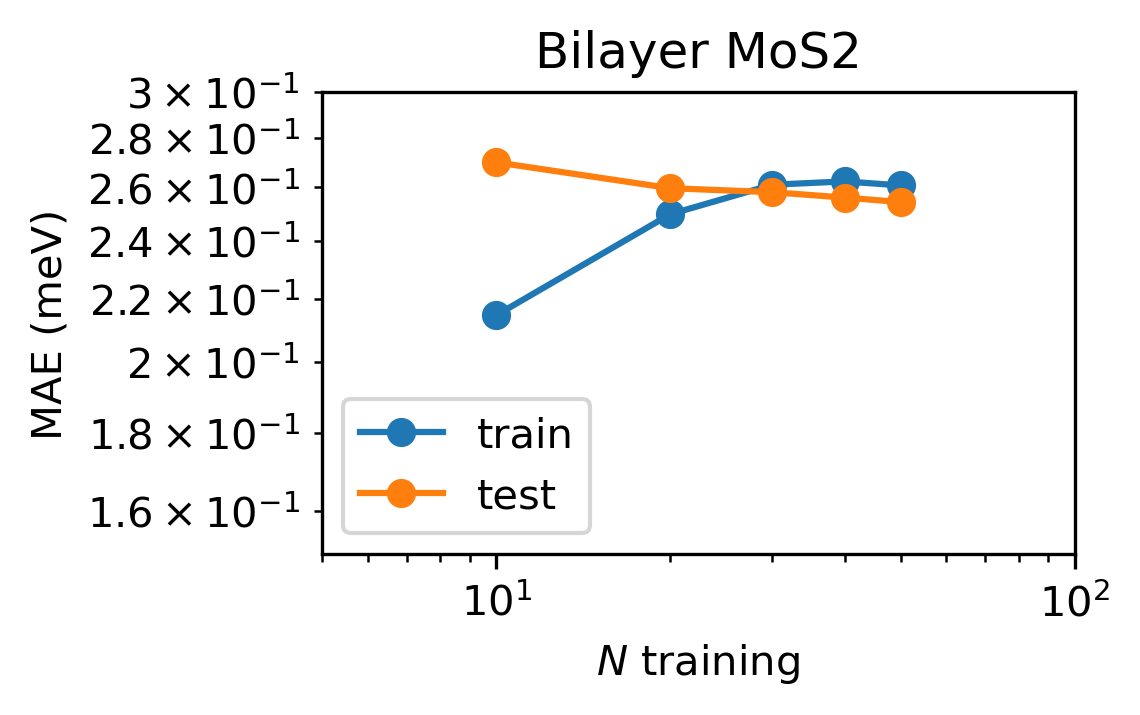

In [61]:
fig, ax = plt.subplots()

# metrics = RMSE
# metrics_name = 'RMSE'

metrics = MAE
metrics_name = 'MAE'

# units_name = 'a.u.'
# units = 1

if metrics_name == 'RMSE':
    metrics = RMSE
elif metrics_name == 'MAE':
    metrics = MAE

from ase.units import Hartree
units_name = 'meV'
units = Hartree*1000

for tset in ['train', 'test']:
    x = np.array([n for n in metrics])
    y = np.array([metrics[n][tset] for n in metrics]) * units
    y = y[x.argsort()]
    x = x[x.argsort()]
    ax.plot(x, y, '-o', label = tset)
    
ax.set_xlabel('$N$ training')
ax.set_ylabel(f'{metrics_name} ({units_name})')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(5, 100)
ax.set_ylim(0.15, 0.3)
ax.set_title('Bilayer MoS2')

In [63]:
plot_atoms?

Signature: plot_atoms(atoms, ax=None, **parameters)
Docstring:
Plot an atoms object in a matplotlib subplot.

Parameters
----------
atoms : Atoms object
ax : Matplotlib subplot object
rotation : str, optional
    In degrees. In the form '10x,20y,30z'
show_unit_cell : int, optional, default 2
    Draw the unit cell as dashed lines depending on value:
    0: Don't
    1: Do
    2: Do, making sure cell is visible
radii : float, optional
    The radii of the atoms
colors : list of strings, optional
    Color of the atoms, must be the same length as
    the number of atoms in the atoms object.
scale : float, optional
    Scaling of the plotted atoms and lines.
offset : tuple (float, float), optional
    Offset of the plotted atoms and lines.
File:      ~/micromamba/envs/sci/lib/python3.11/site-packages/ase/visualize/plot.py
Type:      function

<Axes: >

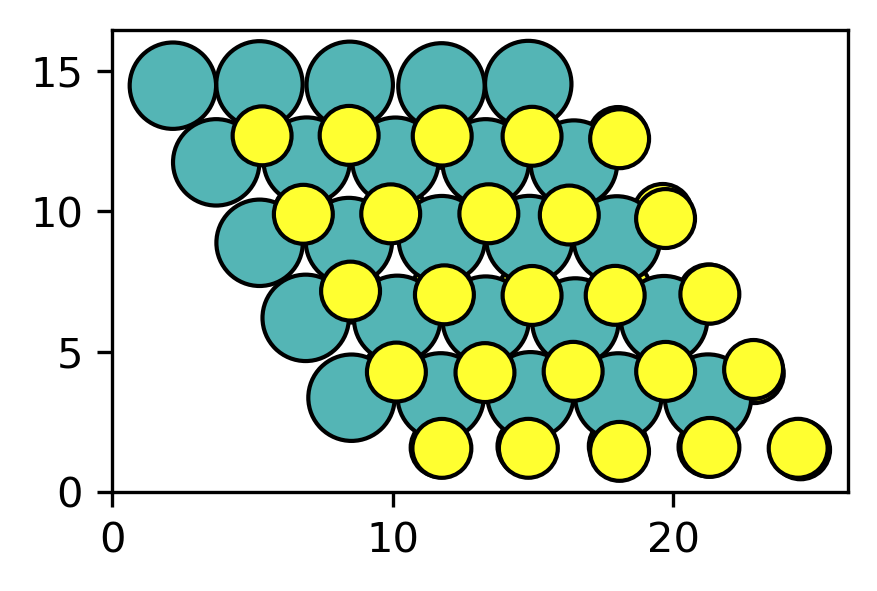

In [64]:
from ase.visualize.plot import plot_atoms
plot_atoms(frames[0], show_unit_cell=False)

In [10]:
np.save('eigval_mos2.npy', eigval_RMSE)

In [17]:
test_prediction = mts.load(f'{train_folder}/predictions_test')
test_pred_eigvals, test_pred_mat = compute_eigenvalues(test_prediction, test_dataset, overlap_matrices = test_overlap_matrices, baseline = test_baseline_target)

(40, 1, 450)

(-65.0, 20.0)

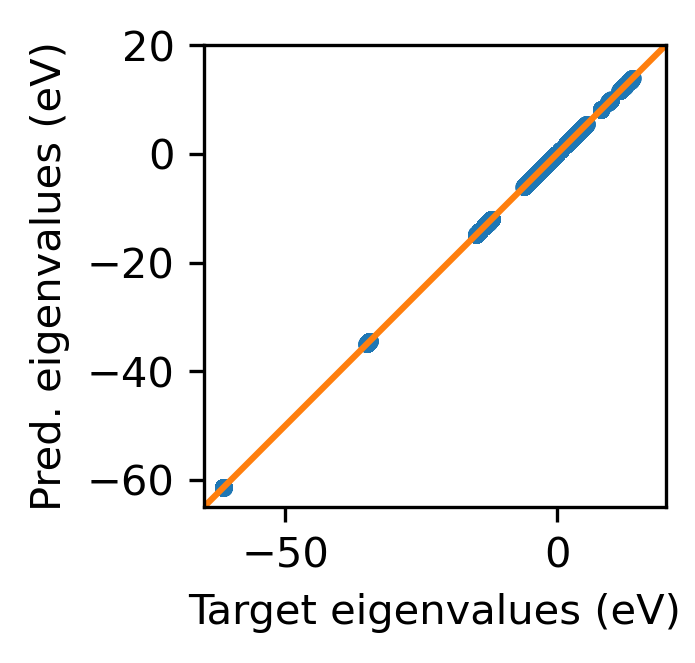

In [55]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

from ase.units import Hartree

x = test_target_eigvals.flatten()*Hartree
for n in [10]: #eigval_RMSE:
    y = eigval_RMSE[n]['test'].flatten()*Hartree
    ax.plot(x, y, '.', alpha = 1, color = 'tab:blue')

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Pred. eigenvalues (eV)')
ax.plot([-70,20], [-70,20], 'tab:orange')
ax.set_xlim(-65,20)
ax.set_ylim(-65,20)

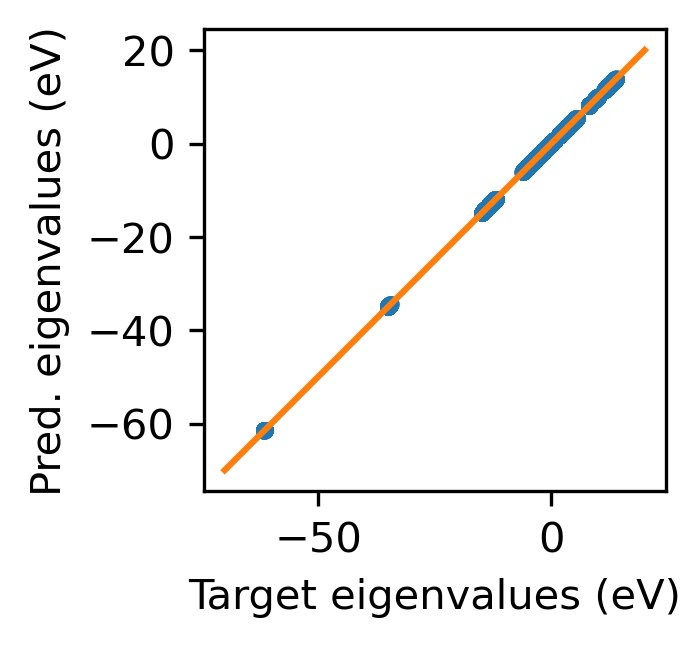

In [43]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

from ase.units import Hartree

# x = train_pred_eigvals.flatten()*Hartree #test_target_eigvals.flatten()*Hartree
# for n in eigval_RMSE:
#     y = eigval_RMSE[n]['train'].flatten()*Hartree
#     ax.plot(x, y, '.', alpha = 1)
ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Pred. eigenvalues (eV)')
ax.plot(train_target_eigvals.flatten()*Hartree, train_pred_eigvals.flatten()*Hartree, '.')
plt.plot([-70,20], [-70,20])

(50, 1, 450)